In [23]:
import os
import sys

# добавляем родительскую папку (корень проекта NUTRITION) в sys.path
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("cwd:", os.getcwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("sys.path contains PROJECT_ROOT:", PROJECT_ROOT in sys.path)


cwd: e:\GitHub\Nutrition\notebooks
PROJECT_ROOT: e:\GitHub\Nutrition
sys.path contains PROJECT_ROOT: True


In [24]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch

from scripts.utils import load_config, train
from scripts.inference import run_inference

# чтобы графики показывались прямо в ноутбуке
%matplotlib inline

# путь к конфигу
CONFIG_PATH = "../configs/base_config.yaml"   
cfg = load_config(CONFIG_PATH)
cfg

{'data': {'dish_csv': 'data/dish.csv',
  'ingredients_csv': 'data/ingredients.csv',
  'images_dir': 'data/images',
  'train_split_name': 'train',
  'test_split_name': 'test'},
 'loader': {'batch_size': 32, 'num_workers': 4, 'shuffle_train': True},
 'train': {'num_epochs': 35,
  'learning_rate': '1e-3',
  'weight_decay': '1e-5',
  'device': 'cuda',
  'seed': 42,
  'save_dir': 'models',
  'save_name': 'best_model.pth'},
 'model': {'backbone_name': 'resnet50', 'pretrained': True, 'dropout': 0.5},
 'augment': {'resize_height': 224,
  'resize_width': 224,
  'horizontal_flip': True},
 'inference': {'batch_size': 32, 'num_workers': 4, 'top_k': 5},
 'logging': {'log_interval': 50, 'metrics_path': 'logs/metrics.csv'}}

In [25]:
def set_seed(seed: int = 42):
    """Фиксируем сиды, чтобы результаты были более стабильными."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(cfg["train"].get("seed", 42))


In [26]:
dish_csv = os.path.join(PROJECT_ROOT, cfg["data"]["dish_csv"])
ingredients_csv = os.path.join(PROJECT_ROOT, cfg["data"]["ingredients_csv"])
images_dir = os.path.join(PROJECT_ROOT, cfg["data"]["images_dir"])

print("dish_csv:", dish_csv)
print("ingredients_csv:", ingredients_csv)
print("images_dir:", images_dir)

# читаем таблицы
dish_df = pd.read_csv(dish_csv)
ingredients_df = pd.read_csv(ingredients_csv)

print("dish_df shape:", dish_df.shape)
print("ingredients_df shape:", ingredients_df.shape)

dish_csv: e:\GitHub\Nutrition\data/dish.csv
ingredients_csv: e:\GitHub\Nutrition\data/ingredients.csv
images_dir: e:\GitHub\Nutrition\data/images
dish_df shape: (3262, 5)
ingredients_df shape: (555, 2)


In [27]:
print("Информация о dish_df:")
print(dish_df.info())

print("\nОписательная статистика по total_calories:")
dish_df["total_calories"].describe()


Информация о dish_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB
None

Описательная статистика по total_calories:


count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64

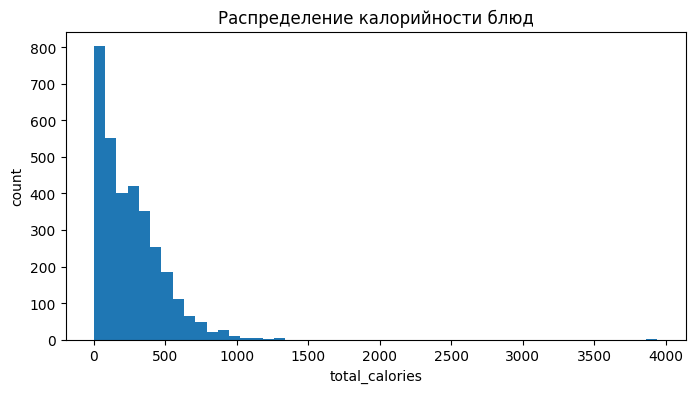

In [28]:
# распределение калорийности
plt.figure(figsize=(8, 4))
plt.hist(dish_df["total_calories"], bins=50)
plt.xlabel("total_calories")
plt.ylabel("count")
plt.title("Распределение калорийности блюд")
plt.show()


In [29]:
# сплиты train/test
print("Уникальные значения split:", dish_df["split"].unique())
dish_df[["dish_id", "total_calories", "total_mass", "ingredients", "split"]].head(10)


Уникальные значения split: ['test' 'train']


,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
5,dish_1565640549,45.482903,139.0,ingr_0000000032;ingr_0000000523;ingr_000000016...,train
6,dish_1563207364,309.269989,271.0,ingr_0000000008;ingr_0000000192;ingr_000000044...,train
7,dish_1561575474,120.058434,183.0,ingr_0000000291;ingr_0000000335;ingr_000000043...,train
8,dish_1563216717,246.007996,332.0,ingr_0000000122;ingr_0000000021;ingr_000000047...,train
9,dish_1565972591,195.199997,122.0,ingr_0000000510,train


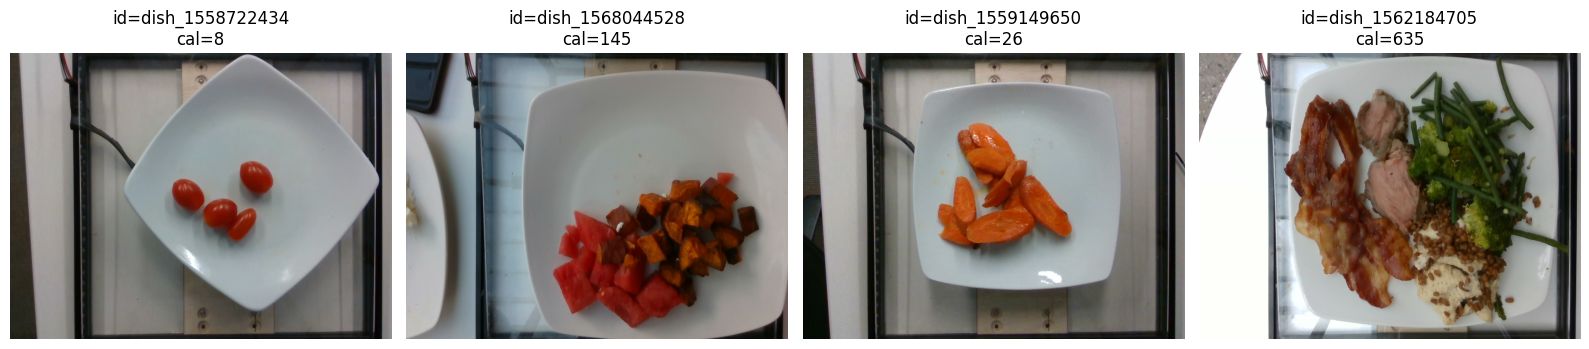

In [30]:
def show_sample_images(df, images_dir, n=4):
    """Показываем n случайных блюд из датафрейма df."""
    sample = df.sample(n)

    plt.figure(figsize=(4 * n, 4))
    for i, (_, row) in enumerate(sample.iterrows(), start=1):
        dish_id = row["dish_id"]
        img_path = os.path.join(images_dir, str(dish_id), "rgb.png")

        if not os.path.exists(img_path):
            print(f"Нет файла: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"id={dish_id}\ncal={row['total_calories']:.0f}")

    plt.tight_layout()
    plt.show()


show_sample_images(
    dish_df[dish_df["split"] == cfg["data"]["train_split_name"]],
    images_dir,
    n=4,
)


In [ ]:
train(CONFIG_PATH)

Используем устройство: cpu
Создаём модель: backbone=resnet50, pretrained=True, dropout=0.5, num_ingredients=555

=== Эпоха 1/35 ===


Train:   0%|          | 0/87 [00:00<?, ?it/s]c:\Users\CHIKOBAVA-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train:  57%|█████▋    | 50/87 [04:46<02:51,  4.63s/it]

Batch [50/87] MAE loss: 130.7713


Train:  64%|██████▍   | 56/87 [05:12<02:14,  4.34s/it]

In [ ]:
# собираем путь к сохранённой модели из конфига
model_path = os.path.join(
    cfg["train"]["save_dir"],
    cfg["train"]["save_name"],
)

# настройки инференса: берём из конфига, если есть, иначе дефолты
inference_cfg = cfg.get("inference", {})
inf_batch_size = inference_cfg.get("batch_size", cfg["loader"]["batch_size"])
inf_num_workers = inference_cfg.get("num_workers", cfg["loader"]["num_workers"])
inf_top_k = inference_cfg.get("top_k", 5)

model_cfg = cfg.get("model", {})

mae_test, worst_df = run_inference(
    dish_csv=dish_csv,
    ingredients_csv=ingredients_csv,
    images_dir=images_dir,
    model_path=model_path,
    batch_size=inf_batch_size,
    num_workers=inf_num_workers,
    top_k=inf_top_k,
    backbone_name=model_cfg.get("backbone_name", "resnet18"),
    dropout=model_cfg.get("dropout", 0.3),
)


print("Финальный MAE на test:", mae_test)
worst_df


Инференс на устройстве: cpu


c:\Users\CHIKOBAVA-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


MAE на test-сплите: 50.3775

Топ-5 блюд с наибольшей ошибкой:
             dish_id  true_calories  pred_calories   abs_error
141  dish_1565811139     902.200012     413.129547  489.070465
423  dish_1563984296     436.337067     739.117249  302.780182
13   dish_1558720236     887.823059     589.795593  298.027466
95   dish_1566316757     448.382874     731.091797  282.708923
298  dish_1558549806     781.958008     502.024811  279.933197
Финальный MAE на test: 50.377479553222656


,dish_id,true_calories,pred_calories,abs_error
141,dish_1565811139,902.200012,413.129547,489.070465
423,dish_1563984296,436.337067,739.117249,302.780182
13,dish_1558720236,887.823059,589.795593,298.027466
95,dish_1566316757,448.382874,731.091797,282.708923
298,dish_1558549806,781.958008,502.024811,279.933197


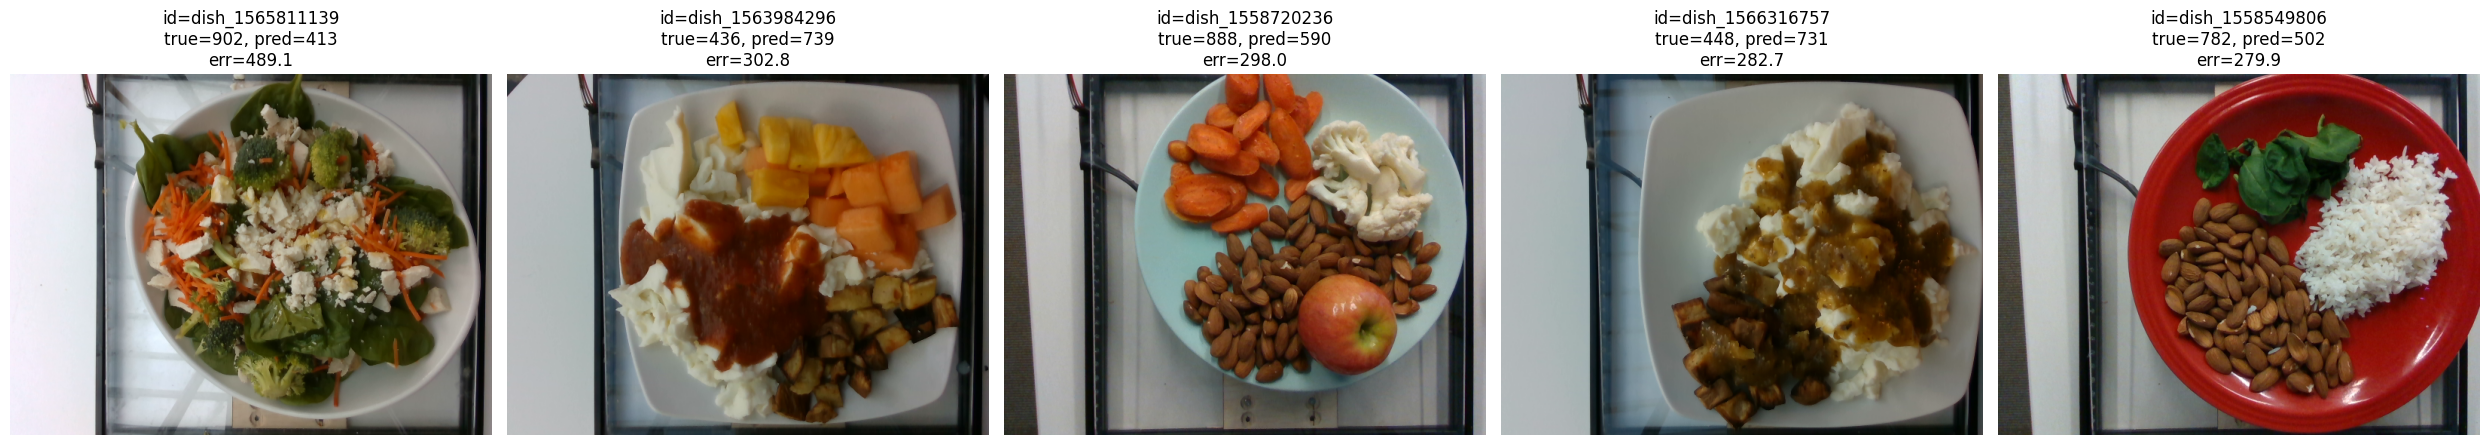

In [ ]:
def show_worst_examples(worst_df, images_dir, n=5):
    """
    Рисуем топ-n примеров с максимальной ошибкой.
    Ожидаем колонки: dish_id, true_calories, pred_calories, abs_error
    """
    worst_df = worst_df.head(n)

    plt.figure(figsize=(5 * n, 5))
    for i, row in enumerate(worst_df.itertuples(), start=1):
        dish_id = row.dish_id
        true_cal = row.true_calories
        pred_cal = row.pred_calories
        err = row.abs_error

        img_path = os.path.join(images_dir, str(dish_id), "rgb.png")
        if not os.path.exists(img_path):
            print(f"Нет файла: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"id={dish_id}\n"
            f"true={true_cal:.0f}, pred={pred_cal:.0f}\n"
            f"err={err:.1f}"
        )

    plt.tight_layout()
    plt.show()


show_worst_examples(worst_df, images_dir, n=inf_top_k)


* Модель использует только картинку, игнорируя ингредиенты и массу блюда. Орехи, колбаса, соусы «выглядят скромно», но реально очень калорийные.
* По фото сверху сложно оценить объём и плотность еды. Видна только площадь на тарелке, но не толщина слоя.
* Визуально похожие блюда могут сильно различаться по калорийности (легкий салат vs салат с маслом и орехами, разные соусы для пасты).
* Возможен дисбаланс в обучающем датасете: мало очень калорийных примеров. Модель тянет предсказания к среднему уровню.
* Базовая архитектура и настройка (простая CNN, ограниченное обучение) дают только грубую оценку «по общему виду», что особенно плохо работает на сложных, многокомпонентных блюдах.
